<a href="https://colab.research.google.com/github/JhonPeterAguilarAtencio/Trabajo-Final-Unidad-III/blob/master/recomendaci_n_anime_basado_en_ratings_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducción

Esta propuesta se basa en **clustering** dado que se busca encontrar grupos con similitudes por sus gustos, para lo cual es vital el rating para cada anime por cada usuario. El objetivo final es que los usuarios queden agrupados según como valoraron los distintos animes.

Para este problema se propone el algoritmo de clústering **K-Means** dada su extensa aplicación y su rápida ejecución. Además se propone antes de utilizar K-Means, reducir la dimensionalidad de los datos con el fin de disminuir los tiempos de entrenamiento.

# Estrategia

En esta problemática de **aprendizaje no supervisado**, se buscar juntar ambas tablas mediante el *anime_id* ejecutando una operación de **INNER-JOIN**. Luego a partir de esta tabla se busca generar una cross-table obteniendo una tabla de tantas filas como usuarios existan, y tantas columnas como animes se encuentren en los datos, teniendo como dato en cada coordenada *i,j* la valoración del usuario *i* para el anime *j*.

# Sistema de recomendación de anime

Ambas tablas contienen información de preferencias de 73.516 usuario en 12.294 anime (series de dibujos animados orientales). Cada usuario puede agregar un anime a su lista y darle un rating (de 0 a 10). La descripción de la data es la siguiente:

Anime.csv 
- anime_id : id único del anime (de la página myanimelist.net) 
- name : nombre del anime 
- genre : lista de generos separados por coma del anime 
- type : TV, movie (de película), OVA, etc… 
- episodes : cantidad de episodios del show (1 si es película) 
- rating : rating promedio (de 1-10) para este anime 
- members : numero de miembros de la comunidad que están en el grupo del anime

Rating.csv 
- user_id : id del usuario generado aleatoriamente 
- anime_id : el anime que el usuario rankeo 
- rating : el rating entre 1 y 10 que el usuario asignó al anime ( -1 si el usuario vio el anime pero no le asignó puntaje)

El objetivo del desafío es desarrollar un sistema de recomendación que permita sugerir anime que los usuarios no han visto, en base a sus ratings previos. Es muy importante justificar la elección del sistema (o modelo), el trabajo previo de la data (EDA) y la documentación de lo que se hizo (no es necesario un informe, pero si comentar porqué se tomaron las decisiones que se tomaron; por ej eliminar una variable o eliminar registros missing, etc).

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

pd.options.display.max_rows = 10

## Carga de datos

In [0]:
name_anime_data =pd.read_csv('anime.csv')
name_rating_data =pd.read_csv('rating.csv') 

In [0]:
df_anime = pd.read_csv(('anime.csv'), index_col='anime_id', sep=',')
df_rating = pd.read_csv(('rating.csv'), sep=',')

## Características datos del dataframe *df_anime*

In [16]:
df_anime.shape

(12294, 6)

In [17]:
df_anime.dtypes

name         object
genre        object
type         object
episodes     object
rating      float64
members       int64
dtype: object

Los episodios también deben ser tratados como números enteros. Veamos los posibles valores de esta columna

## Tratamiento de datos para el dataframe *df_anime*

### Tratamiento columna episodes

In [18]:
df_anime.episodes.value_counts()

1       5677
2       1076
12       816
13       572
26       514
        ... 
330        1
1787       1
163        1
85         1
154        1
Name: episodes, Length: 187, dtype: int64

Como podemos ver, existen valores 'Unknown', para los cuales daremos un valor entero negativo constante. En este caso **-1**. A pesar de ser una minima parte que conforma este grupo con respecto al total, se prefiere no borrar, ni tampoco utilizar media, mediana o moda, puesto que existen valores atípicos, por lo que se genera un nuevo grupo distintivo.

In [0]:
df_anime.loc[df_anime.episodes == 'Unknown', 'episodes'] = -1

In [0]:
df_anime.episodes = pd.to_numeric(df_anime.episodes)

In [21]:
df_anime.dtypes

name         object
genre        object
type         object
episodes      int64
rating      float64
members       int64
dtype: object

Como podemos ver, sin ningún problema la columna fue *casteada* a valor entero.
- NOTA: Casting es convertir el tipo de dato que posee una variable.

In [22]:
df_anime.describe()

,episodes,rating,members
count,12294.000000,12064.000000,1.229400e+04
mean,12.012445,6.473902,1.807134e+04
std,46.264788,1.026746,5.482068e+04
min,-1.000000,1.670000,5.000000e+00
25%,1.000000,5.880000,2.250000e+02
50%,2.000000,6.570000,1.550000e+03
75%,12.000000,7.180000,9.437000e+03
max,1818.000000,10.000000,1.013917e+06


In [23]:
df_anime.episodes.describe()

count    12294.000000
mean        12.012445
std         46.264788
min         -1.000000
25%          1.000000
50%          2.000000
75%         12.000000
max       1818.000000
Name: episodes, dtype: float64

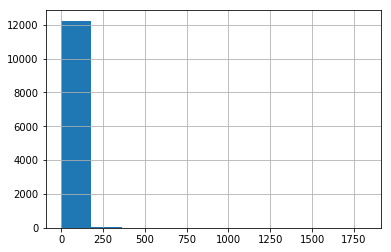

In [24]:
df_anime.episodes.hist()

### Tratamiento columna genre

Inicialmente borraria los anime sin género, ya que considero que es demasiado importante para la recomendación
 - Sin género no existe relación directa con los gustos del usuario
 - Sin embargo podría darse una relación implícita en el rating de otros usuarios con el fin de categorizar a dichos anime. Así mismo de acuerdo al gusto de los usuarios podrían caer en alguna categoría y obtener dicha etiqueta.

In [25]:
df_anime.loc[df_anime.genre.isnull()]

,name,genre,type,episodes,rating,members
anime_id,,,,,,
33242,IS: Infinite Stratos 2 - Infinite Wedding,NaN,Special,1,7.15,6604
33589,ViVid Strike!,NaN,TV,12,6.96,12345
29765,Metropolis (2009),NaN,Movie,1,6.27,313
32695,Match Shoujo,NaN,ONA,1,6.02,242
33187,Katsudou Shashin,NaN,Movie,1,5.79,607
...,...,...,...,...,...,...
32032,Seikaisuru Kado,NaN,NaN,-1,NaN,1797
34310,Tamagotchi Movie: Tanpen Himitsu no Otodoke Da...,NaN,Movie,1,NaN,51
34474,Tsukipro The Animation,NaN,TV,-1,NaN,843


Si bien la cantidad de registros en la tabla anime con valores null es mínima, de igual forma estos tienen un rating asignado y es importante considerarlos por lo que se toma la decisión de crear un nuevo valor **'No Genre'** para estos valores.

In [0]:
df_anime.genre.fillna('No Genre',inplace=True)

In [27]:
df_anime.count()

name        12294
genre       12294
type        12269
episodes    12294
rating      12064
members     12294
dtype: int64

**IMPORTANTE**: Un **mínimo** de registros tiene valor NaN en *type* y también en *episodes* y *rating*.

### Tratamiento columna *type*

In [28]:
df_anime.loc[df_anime.type.isna()]

,name,genre,type,episodes,rating,members
anime_id,,,,,,
30484,Steins;Gate 0,"Sci-Fi, Thriller",NaN,-1,NaN,60999
34437,Code Geass: Fukkatsu no Lelouch,"Action, Drama, Mecha, Military, Sci-Fi, Super ...",NaN,-1,NaN,22748
33352,Violet Evergarden,"Drama, Fantasy",NaN,-1,NaN,20564
33248,K: Seven Stories,"Action, Drama, Super Power, Supernatural",NaN,-1,NaN,22133
33845,Free! (Shinsaku),"School, Sports",NaN,-1,NaN,8666
...,...,...,...,...,...,...
34348,Rescue Academia,Drama,NaN,-1,NaN,65
32032,Seikaisuru Kado,No Genre,NaN,-1,NaN,1797
33478,UQ Holder!,"Action, Fantasy, Magic, Sci-Fi, Shounen",NaN,-1,NaN,2341


Como podemos ver, en los registros(o rows) con valor NaN en la columna *type* coincide que en todas existe falta de información en las columnas *episodes* y *rating*, siendo esta última razón para ser eliminada siguiendo la estrategia. Sin embargo compararemos el número de miembros de cada uno de estos registros con respecto a los demás.

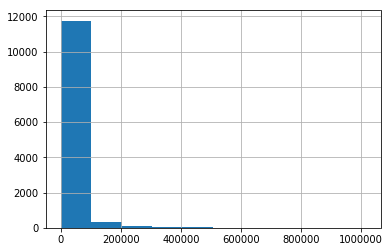

In [30]:
df_anime.members.hist()

In [31]:
pd.Series(df_anime.members.describe(),dtype='int64')

count      12294
mean       18071
std        54820
min            5
25%          225
50%         1550
75%         9437
max      1013917
Name: members, dtype: int64

Borramos los valores NaN

In [0]:
df_anime = df_anime.dropna(0, subset=['type'])

In [34]:
pd.isnull(df_anime).sum()

name          0
genre         0
type          0
episodes      0
rating      205
members       0
dtype: int64

In [35]:
df_anime.describe()

,episodes,rating,members
count,12269.00000,12064.000000,1.226900e+04
mean,12.03896,6.473902,1.809484e+04
std,46.30817,1.026746,5.487089e+04
min,-1.00000,1.670000,5.000000e+00
25%,1.00000,5.880000,2.240000e+02
50%,2.00000,6.570000,1.549000e+03
75%,12.00000,7.180000,9.453000e+03
max,1818.00000,10.000000,1.013917e+06


In [36]:
df_anime.count()

name        12269
genre       12269
type        12269
episodes    12269
rating      12064
members     12269
dtype: int64

### Tratamiento columna rating

In [37]:
df_anime.loc[pd.isna(df_anime.rating)]

,name,genre,type,episodes,rating,members
anime_id,,,,,,
34502,Inazma Delivery,"Action, Comedy, Sci-Fi",TV,10,NaN,32
34309,Nananin no Ayakashi: Chimi Chimi Mouryou!! Gen...,"Comedy, Supernatural",TV,-1,NaN,129
34096,Gintama (2017),"Action, Comedy, Historical, Parody, Samurai, S...",TV,-1,NaN,13383
34134,One Punch Man 2,"Action, Comedy, Parody, Sci-Fi, Seinen, Super ...",TV,-1,NaN,90706
25777,Shingeki no Kyojin Season 2,"Action, Drama, Fantasy, Shounen, Super Power",TV,-1,NaN,170054
...,...,...,...,...,...,...
34492,Nuki Doki! Tenshi to Akuma no Sakusei Battle -...,Hentai,OVA,-1,NaN,392
34491,Sagurare Otome The Animation,Hentai,OVA,1,NaN,79
34312,Saimin Class,Hentai,OVA,-1,NaN,240


Como podemos ver, lo más probable es que estos anime aún no sean vistos, por lo que podrían no ser recomendamos simplemente (dado que no tienen rating) o ser considerados por su género, puesto que claramente los géneros pertenecientes a un anime son una relación con otros. Sin embargo estos valores NaN en la columna rating sean tratados o no, serán eliminados al ejecutar la operación **INNER JOIN** con la tabla(o dataframe) rating, puesto que no existen usuarios en la tabla rating que hayan evaluado al anime de la tabla anime.
Para esta ocasión excepcional, tomo la decisión de no considerar a los valores NaN en rating, dado la mínima parte que conforman con respecto al total. Sin embargo, si fuesen una gran parte(o mayor), utilizaría la estrategia de ejecutar una operación **OUTER JOIN** entre ambas tablas y trataría de otra manera los valores NaN en rating.

In [38]:
df_anime.count()

name        12269
genre       12269
type        12269
episodes    12269
rating      12064
members     12269
dtype: int64

In [39]:
nro_total_ratings = df_anime.rating.shape[0]
nro_total_ratings

12269

In [40]:
df_anime.loc[df_anime.rating.isnull()].shape

(205, 6)

In [41]:
nro_nulls = pd.isna(df_anime.rating).sum()
nro_nulls

205

## Gráfico ratings válidos vs nulls

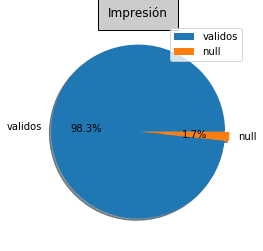

In [42]:
impr = ["validos", "null"]
vol = [nro_total_ratings-nro_nulls, nro_nulls]
expl =(0, 0.05)
plt.pie(vol, explode=expl, labels=impr, autopct='%1.1f%%', shadow=True)
plt.title("Impresión", bbox={"facecolor":"0.8", "pad":10})
plt.legend()

A pesar de ser una cantidad tan baja de valores null, como antes ya se explicó, con la estrategia seguida se eliminan si o sí dado que se busca generar un dataset mediante una operación **INNER JOIN** entre ambas tablas.

In [0]:
df_anime = df_anime.dropna(0, subset=['rating']) # borramos las filas con valores de rating na

In [44]:
pd.isna(df_anime).sum()

name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64

In [45]:
df_anime.index.is_unique # nos aseguramos que el índice sea único

True

In [46]:
df_anime.shape

(12064, 6)

In [47]:
df_anime.count()

name        12064
genre       12064
type        12064
episodes    12064
rating      12064
members     12064
dtype: int64

In [48]:
df_anime[['episodes', 'rating']].describe()

,episodes,rating
count,12064.000000,12064.000000
mean,12.237732,6.473902
std,46.673023,1.026746
min,-1.000000,1.670000
25%,1.000000,5.880000
50%,2.000000,6.570000
75%,12.000000,7.180000
max,1818.000000,10.000000


## Interesante ver donde está concentrada la mayoría de los ratings

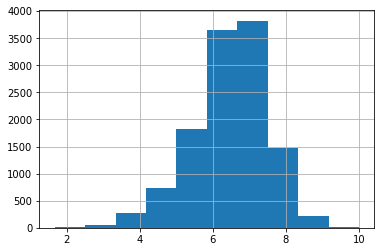

In [49]:
df_anime['rating'].hist()

In [50]:
df_anime.loc[df_anime.rating > 9]

,name,genre,type,episodes,rating,members
anime_id,,,,,,
32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...
33607,Kahei no Umi,Historical,Movie,1,9.33,44
23005,Mogura no Motoro,Slice of Life,Movie,1,9.50,62
30120,Spoon-hime no Swing Kitchen,"Adventure, Kids",TV,-1,9.60,47


## Tratamiento de datos del dataframe *df_rating*

### Característica de los datos del dataframe *df_rating*

In [51]:
df_rating.shape

(7813737, 3)

In [52]:
df_rating.count()

user_id     7813737
anime_id    7813737
rating      7813737
dtype: int64

In [53]:
df_rating.dtypes

user_id     int64
anime_id    int64
rating      int64
dtype: object

In [54]:
pd.isnull(df_rating).sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [55]:
df_rating.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


### Tratamiento datos columna *rating*

In [56]:
np.round(df_rating[['rating']].describe(), 2)

,rating
count,7813737.00
mean,6.14
std,3.73
min,-1.00
25%,6.00
50%,7.00
75%,9.00
max,10.00


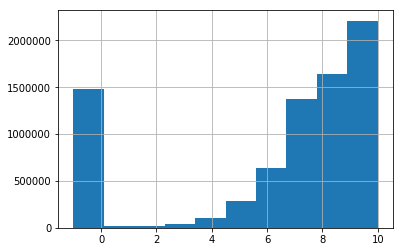

In [57]:
df_rating.rating.hist()

In [58]:
df_rating[['user_id', 'rating']].groupby(['user_id']).mean().merge(
    df_rating[['user_id', 'rating']].groupby(
    ['user_id']).count(),left_on='user_id', right_on='user_id') # veamos el rating promedio y el numero de personas

,rating_x,rating_y
user_id,,
1,-0.712418,153
2,2.666667,3
3,7.382979,94
4,-1.000000,52
5,4.263383,467
...,...,...
73512,7.846154,13
73513,7.515152,33
73514,10.000000,1


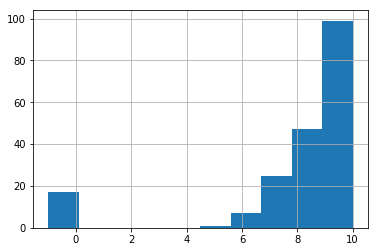

In [59]:
df_rating.loc[(df_rating.user_id == 73515)]['rating'].hist()

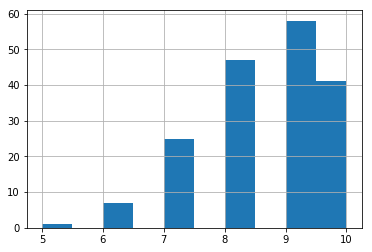

In [60]:
df_rating.loc[(df_rating.user_id == 73515)&(df_rating.rating>=1)]['rating'].hist()

# Decisión para la columna *rating*

Si bien una gran parte de este dataframe se compone de valores -1(usuario vió pero no evaluó) estos estan distribuidos por usuario en pequeñas porciones. Tomando en cuenta que el objetivo es encontrar similitudes entre los gustos de los usuarios, se toma le decisión de rellenar con el promedio de sus ratings **sin** considerar los valores -1 para dicho cálculo.

Verificamos que no existan valores no válidos como menores 0(pero mayores a -1) o mayores a 10.

In [0]:
df_rating.loc[(df_rating.rating < 0)&(df_rating.rating > -1)|(df_rating.rating > 10)]

,user_id,anime_id,rating


In [0]:
df_rating

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
...,...,...,...
7813732,73515,16512,7
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9


In [0]:
df_rating = df_rating.merge(df_rating[['user_id', 'rating']].loc[df_rating.rating >=1].groupby(['user_id']).mean(), on='user_id',
               suffixes=('', '_prom'))

In [0]:
df_rating

,user_id,anime_id,rating,rating_prom
0,1,20,-1,10.000000
1,1,24,-1,10.000000
2,1,79,-1,10.000000
3,1,226,-1,10.000000
4,1,241,-1,10.000000
...,...,...,...,...
7422051,73515,16512,7,8.547486
7422052,73515,17187,9,8.547486
7422053,73515,22145,10,8.547486
7422054,73516,790,9,9.000000


In [0]:
df_rating['rating'].loc[df_rating.rating == -1] = df_rating['rating_prom']

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [0]:
df_rating.loc[df_rating.user_id == 73515].rating.value_counts()

9.000000     58
8.000000     47
10.000000    41
7.000000     25
8.547486     17
6.000000      7
5.000000      1
Name: rating, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5dd4912128>]],
      dtype=object)

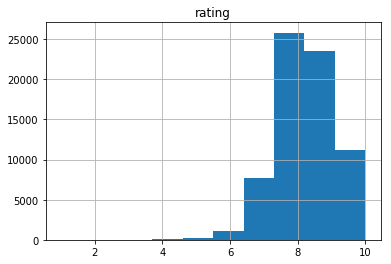

In [0]:
df_rating[['user_id', 'rating']].groupby(['user_id']).mean().hist()

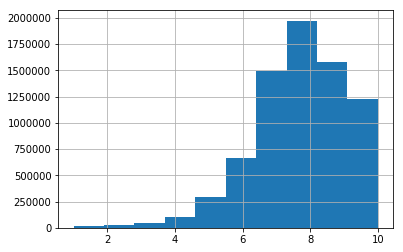

In [0]:
df_rating['rating'].hist()

# Join

Una vez tratados los datos de ambos dataframe se ejecuta la operación **INNER-JOIN** entre ambos con el objetivo de relacionar el anime con la valoración de cada usuario.

In [0]:
df_inner = df_rating.merge(df_anime.sample(n=100),on='anime_id', how='inner')

In [0]:
df_inner

,user_id,anime_id,rating_x,rating_prom,name,genre,type,episodes,rating_y,members
0,1,8841,10.0,10.000000,Kore wa Zombie Desu ka?,"Action, Comedy, Ecchi, Harem, Magic, Supernatural",TV,12,7.67,295782
1,5,8841,5.0,4.355120,Kore wa Zombie Desu ka?,"Action, Comedy, Ecchi, Harem, Magic, Supernatural",TV,12,7.67,295782
2,17,8841,6.0,6.901720,Kore wa Zombie Desu ka?,"Action, Comedy, Ecchi, Harem, Magic, Supernatural",TV,12,7.67,295782
3,25,8841,6.0,7.973684,Kore wa Zombie Desu ka?,"Action, Comedy, Ecchi, Harem, Magic, Supernatural",TV,12,7.67,295782
4,27,8841,9.0,8.569620,Kore wa Zombie Desu ka?,"Action, Comedy, Ecchi, Harem, Magic, Supernatural",TV,12,7.67,295782
...,...,...,...,...,...,...,...,...,...,...
85536,66532,6629,10.0,8.012195,Asari-chan,"Comedy, Shoujo, Slice of Life",TV,54,6.55,263
85537,68465,6629,7.0,8.271403,Asari-chan,"Comedy, Shoujo, Slice of Life",TV,54,6.55,263
85538,47456,7715,4.0,6.694335,Auto Mommy,Fantasy,Movie,1,5.12,173
85539,60978,28989,5.0,6.676558,Maku,Dementia,Movie,1,6.18,86


In [0]:
df_inner.shape

(85541, 10)

In [0]:
pd.isna(df_inner).sum()

user_id        0
anime_id       0
rating_x       0
rating_prom    0
name           0
genre          0
type           0
episodes       0
rating_y       0
members        0
dtype: int64

In [0]:
df_inner

,user_id,anime_id,rating_x,rating_prom,name,genre,type,episodes,rating_y,members
0,1,8841,10.0,10.000000,Kore wa Zombie Desu ka?,"Action, Comedy, Ecchi, Harem, Magic, Supernatural",TV,12,7.67,295782
1,5,8841,5.0,4.355120,Kore wa Zombie Desu ka?,"Action, Comedy, Ecchi, Harem, Magic, Supernatural",TV,12,7.67,295782
2,17,8841,6.0,6.901720,Kore wa Zombie Desu ka?,"Action, Comedy, Ecchi, Harem, Magic, Supernatural",TV,12,7.67,295782
3,25,8841,6.0,7.973684,Kore wa Zombie Desu ka?,"Action, Comedy, Ecchi, Harem, Magic, Supernatural",TV,12,7.67,295782
4,27,8841,9.0,8.569620,Kore wa Zombie Desu ka?,"Action, Comedy, Ecchi, Harem, Magic, Supernatural",TV,12,7.67,295782
...,...,...,...,...,...,...,...,...,...,...
85536,66532,6629,10.0,8.012195,Asari-chan,"Comedy, Shoujo, Slice of Life",TV,54,6.55,263
85537,68465,6629,7.0,8.271403,Asari-chan,"Comedy, Shoujo, Slice of Life",TV,54,6.55,263
85538,47456,7715,4.0,6.694335,Auto Mommy,Fantasy,Movie,1,5.12,173
85539,60978,28989,5.0,6.676558,Maku,Dementia,Movie,1,6.18,86


De ahora en adelante para reducir los tiempos para las pruebas trabajaremos con un dataframe de muestra obtenido aleatoriamente.

In [0]:
df_inner_sample = df_inner

In [0]:
df_inner_sample

,user_id,anime_id,rating_x,rating_prom,name,genre,type,episodes,rating_y,members
0,1,8841,10.0,10.000000,Kore wa Zombie Desu ka?,"Action, Comedy, Ecchi, Harem, Magic, Supernatural",TV,12,7.67,295782
1,5,8841,5.0,4.355120,Kore wa Zombie Desu ka?,"Action, Comedy, Ecchi, Harem, Magic, Supernatural",TV,12,7.67,295782
2,17,8841,6.0,6.901720,Kore wa Zombie Desu ka?,"Action, Comedy, Ecchi, Harem, Magic, Supernatural",TV,12,7.67,295782
3,25,8841,6.0,7.973684,Kore wa Zombie Desu ka?,"Action, Comedy, Ecchi, Harem, Magic, Supernatural",TV,12,7.67,295782
4,27,8841,9.0,8.569620,Kore wa Zombie Desu ka?,"Action, Comedy, Ecchi, Harem, Magic, Supernatural",TV,12,7.67,295782
...,...,...,...,...,...,...,...,...,...,...
85536,66532,6629,10.0,8.012195,Asari-chan,"Comedy, Shoujo, Slice of Life",TV,54,6.55,263
85537,68465,6629,7.0,8.271403,Asari-chan,"Comedy, Shoujo, Slice of Life",TV,54,6.55,263
85538,47456,7715,4.0,6.694335,Auto Mommy,Fantasy,Movie,1,5.12,173
85539,60978,28989,5.0,6.676558,Maku,Dementia,Movie,1,6.18,86


In [0]:
df_inner_sample.shape

(85541, 10)

Dado que el objetivo es ejecutar el algoritmo **K-Means** con la valoración que le dio cada usuario a cada anime es que hacemos una tabla cruzada de la siguiente manera.

In [0]:
df_rating_animes = pd.crosstab(df_inner_sample['user_id'], df_inner_sample['name'], values=df_inner_sample['rating_x'], aggfunc=['mean'])

El nuevo dataframe contiene las valoraciones que dio cada usuario para cada anime.

In [0]:
df_rating_animes

mean                     ...                                            
name    AWOL Ai Tenchi Muyou!    ...     Yama no Susume Second Season Yoru no Hi
user_id                          ...                                            
1        NaN              NaN    ...                              NaN        NaN
5        NaN              NaN    ...                              NaN        NaN
7        NaN              NaN    ...                              NaN        NaN
9        NaN              NaN    ...                              NaN        NaN
11       NaN              NaN    ...                              NaN        NaN
...      ...              ...    ...                              ...        ...
73507    NaN              NaN    ...                              NaN        NaN
73510    NaN              NaN    ...                              NaN        NaN
73511    NaN              NaN    ...                              NaN        NaN
73513    NaN              NaN    ...                              NaN        NaN
73515    NaN              NaN    ...                              NaN        NaN

[37753 rows x 81 columns]

In [0]:
df_rating_animes = df_rating_animes.fillna(value=0.0)

In [0]:
df_rating_animes

mean                     ...                                            
name    AWOL Ai Tenchi Muyou!    ...     Yama no Susume Second Season Yoru no Hi
user_id                          ...                                            
1        0.0              0.0    ...                              0.0        0.0
5        0.0              0.0    ...                              0.0        0.0
7        0.0              0.0    ...                              0.0        0.0
9        0.0              0.0    ...                              0.0        0.0
11       0.0              0.0    ...                              0.0        0.0
...      ...              ...    ...                              ...        ...
73507    0.0              0.0    ...                              0.0        0.0
73510    0.0              0.0    ...                              0.0        0.0
73511    0.0              0.0    ...                              0.0        0.0
73513    0.0              0.0    ...                              0.0        0.0
73515    0.0              0.0    ...                              0.0        0.0

[37753 rows x 81 columns]

In [0]:
df_rating_animes.shape

(37753, 81)

Dada la gran cantidad de columnas se procede a ejecutar *PCA* con el objetivo de reducir la dimensionalidad de los datos teniendo periodos de entrenamiento más cortos.

In [0]:
scaler = MinMaxScaler(feature_range=[0, 1])
data_rescaled = scaler.fit_transform(df_rating_animes)

In [0]:
data_rescaled

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [0]:
data_rescaled.shape

(37753, 81)

In [0]:
pca = PCA().fit(data_rescaled)

# Determinemos el número de componentes para PCA

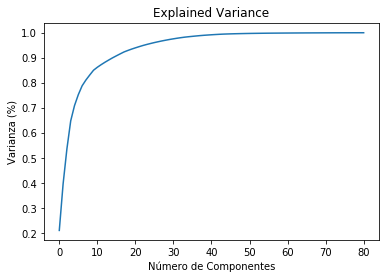

In [0]:
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza (%)') #for each component
plt.title('Explained Variance')
plt.show()

De las 89 dimensiones, podemos reducir a 49 componentes principales sin degradar considerablemente el dataset.

In [0]:
np.cumsum(pca.explained_variance_ratio_)[49]

0.9969516560002657

Como podemos ver, en vez de usar todas las columnas, podemos usar directamente considerablemente menos teniendo una mínima degradación del dataset.

In [0]:
pca = PCA(n_components=49)
dataset = pca.fit_transform(data_rescaled)

Además con el fin de comparar resultados finales, aplicaremos PCA para 3 componentes.

In [0]:
pca_deg = PCA(n_components=3)
dataset_deg = pca_deg.fit_transform(data_rescaled)

In [0]:
dataset.shape

(37753, 49)

In [0]:
X = dataset
X_deg = dataset_deg
#y = np.array(df_completo['anime_id'])
X.shape


(37753, 49)

In [0]:
X_deg.shape

(37753, 3)

Teniendo nuestro dataset reescalado y reducido, podemos comenzar con el algoritmo de clustering **K-Means**

## Determinemos el número de clústers mediante el método *Elbow Curve*

In [0]:
def elbow_curve(X):
    n_clusters = range(1, 10)
    kmeans = [KMeans(n_clusters=i) for i in n_clusters]
    kmeans
    score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
    score
    plt.plot(n_clusters,score)
    plt.xlabel('Número de clústers')
    plt.ylabel('Score')
    plt.title('Elbow Curve')
    plt.show()

Para el dataset resultante de PCA con bajo degradamiento.

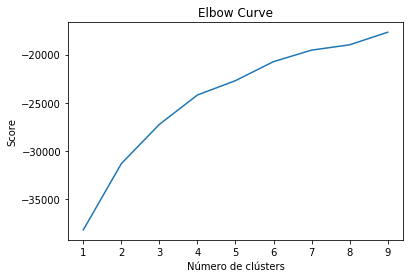

In [0]:
elbow_curve(X)

Para el dataset resultante de PCA con 3 componentes.

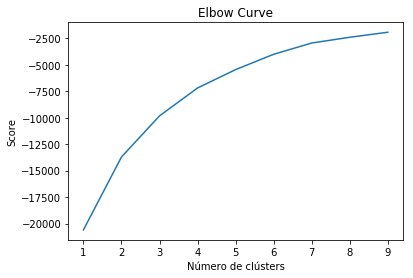

In [0]:
elbow_curve(X_deg)

Los resultados mediante *Elbow Curve* no son muy claros, por lo que se utilizará el método *Silhouette Score*

## Determinemos el número de clústers mediante el método *Silhouette Score*

In [0]:
def silhouette_score_sk(X):
    # EJEMPLO EXTRAÍDO DE SKLEARN POR EL TIPO DE GRÁFICO, créditos a sklearn.
    range_n_clusters = [2, 3, 4, 5, 6]
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

    plt.show()

Obtenemos los gráficos con ambos dataset con el fin de comparar.

For n_clusters = 2 The average silhouette_score is : 0.21189112493608897
For n_clusters = 3 The average silhouette_score is : 0.21893761338659176
For n_clusters = 4 The average silhouette_score is : 0.2556712319464705
For n_clusters = 5 The average silhouette_score is : 0.264197578450666
For n_clusters = 6 The average silhouette_score is : 0.28545894515520615


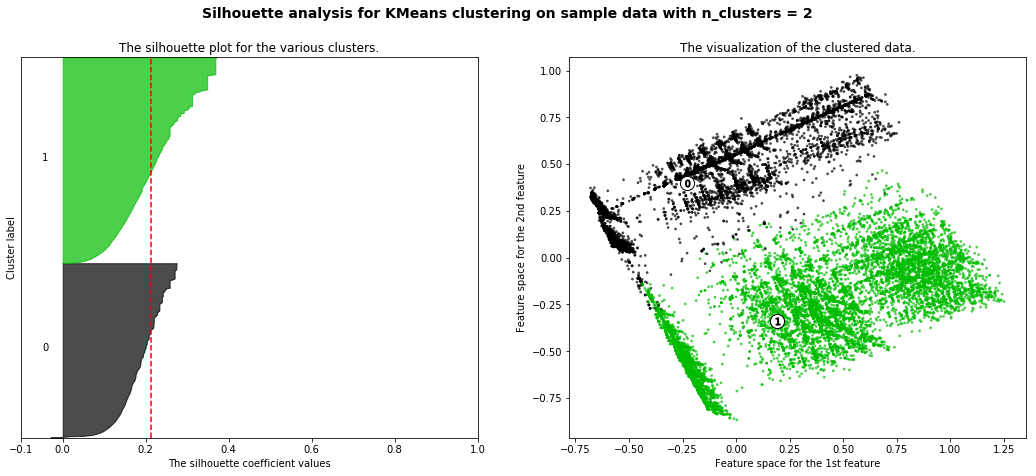

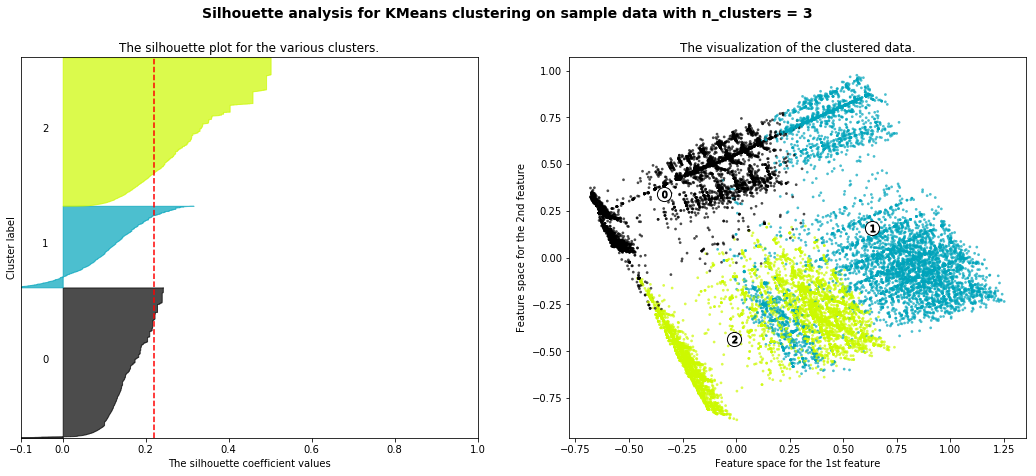

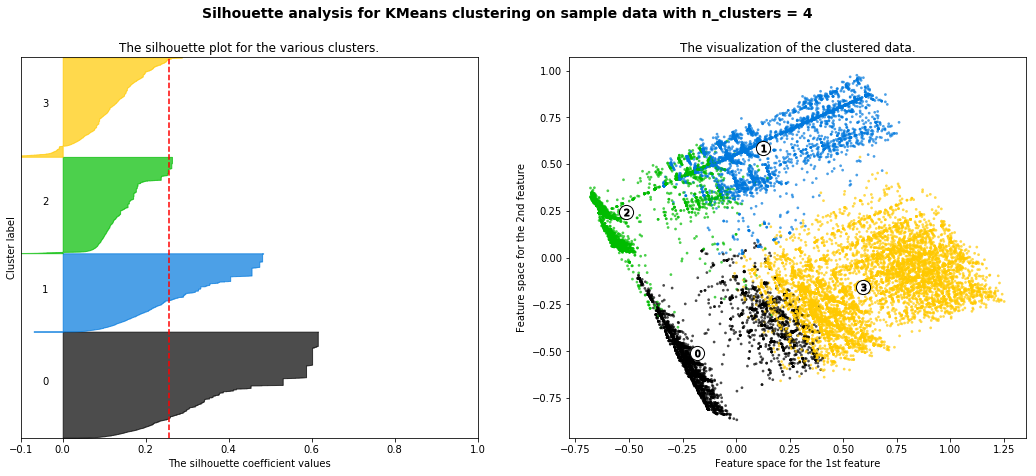

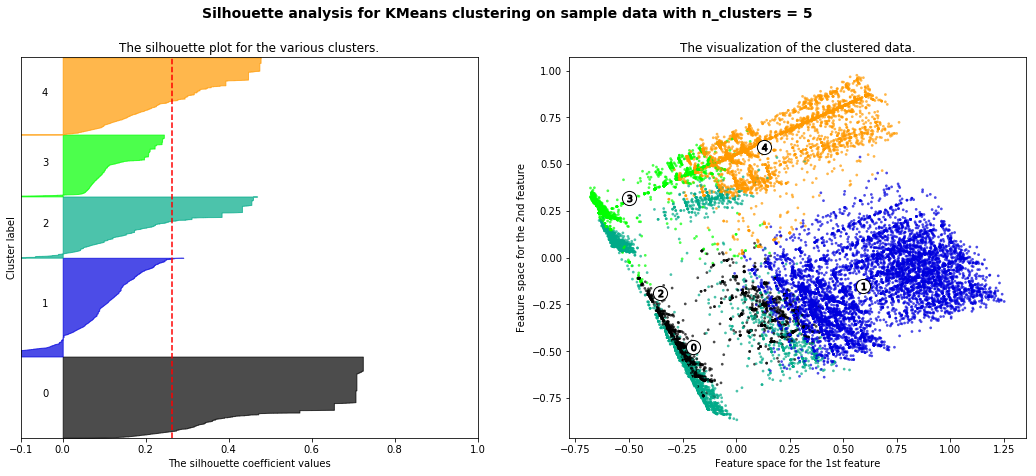

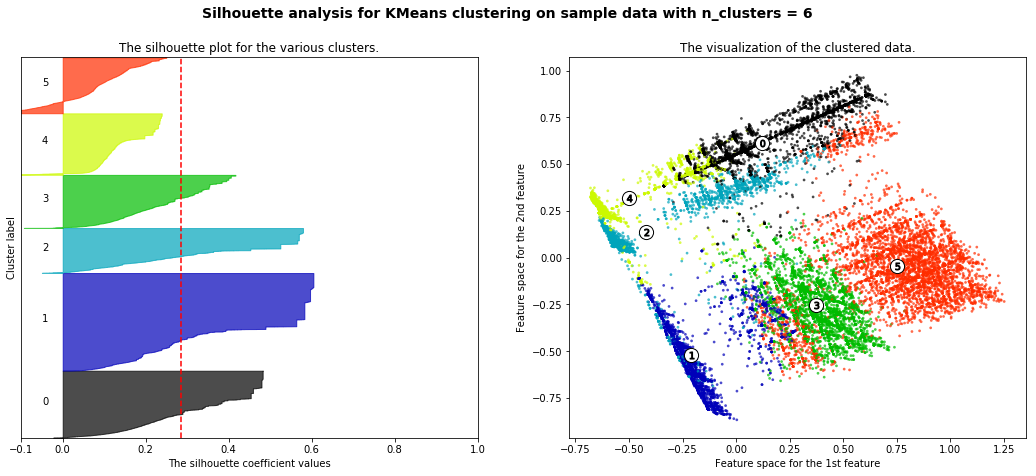

In [0]:
silhouette_score_sk(X)

For n_clusters = 2 The average silhouette_score is : 0.3661542629042865
For n_clusters = 3 The average silhouette_score is : 0.39652055970138567
For n_clusters = 4 The average silhouette_score is : 0.44426843916292863
For n_clusters = 5 The average silhouette_score is : 0.49057508528544097
For n_clusters = 6 The average silhouette_score is : 0.5278611550760443


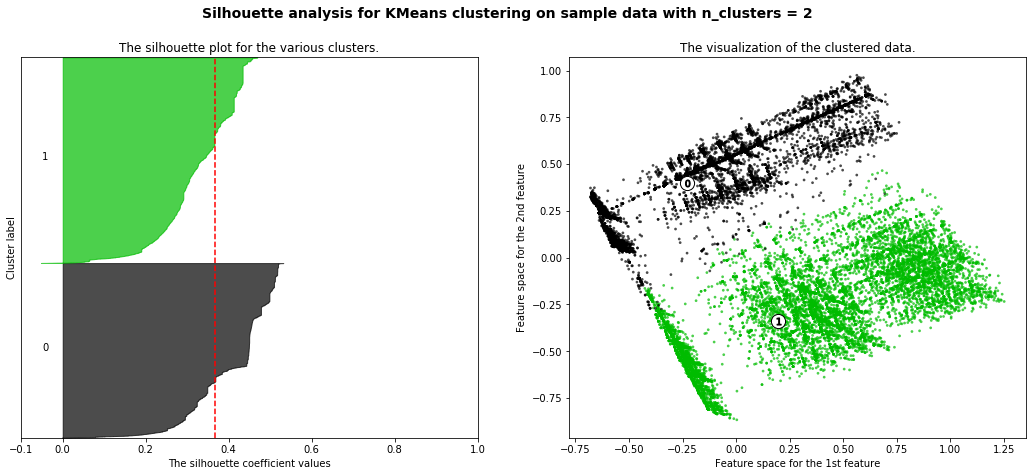

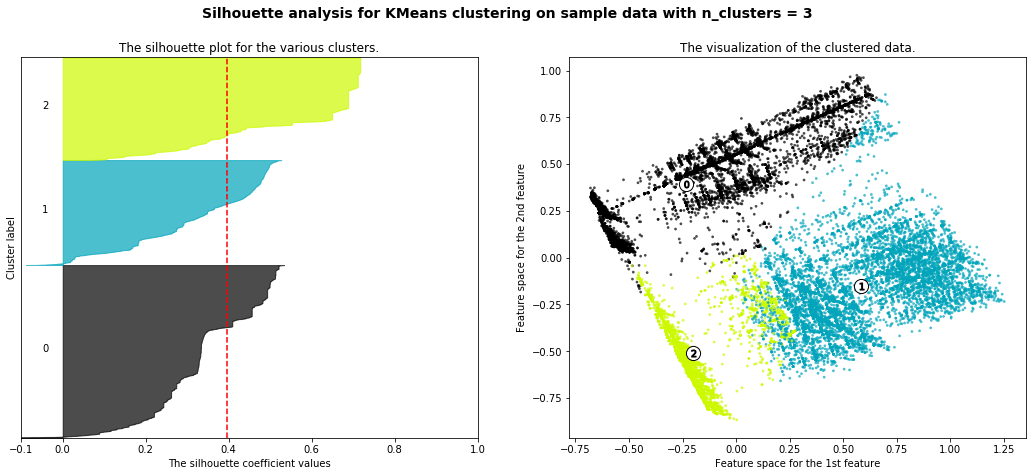

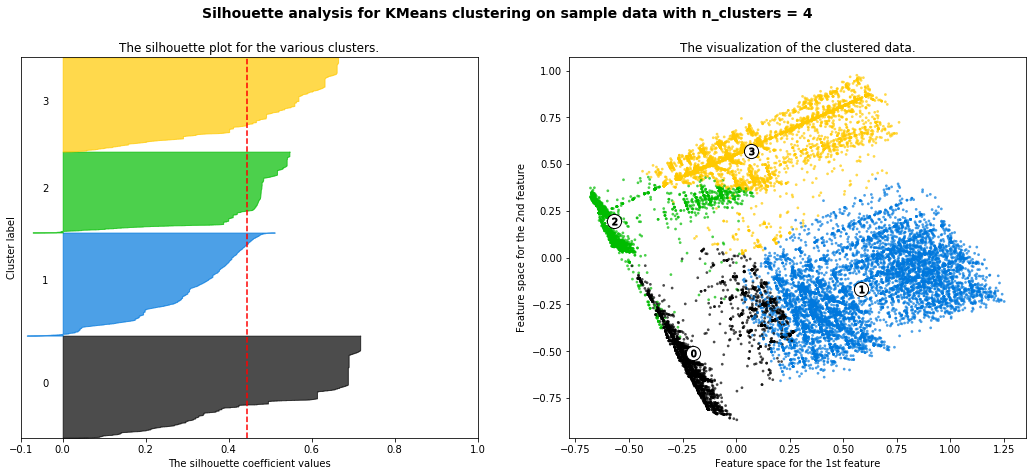

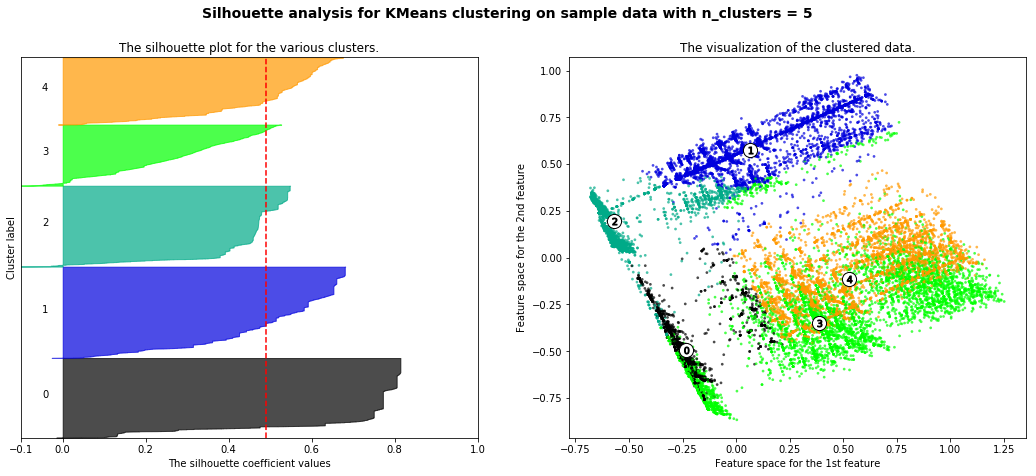

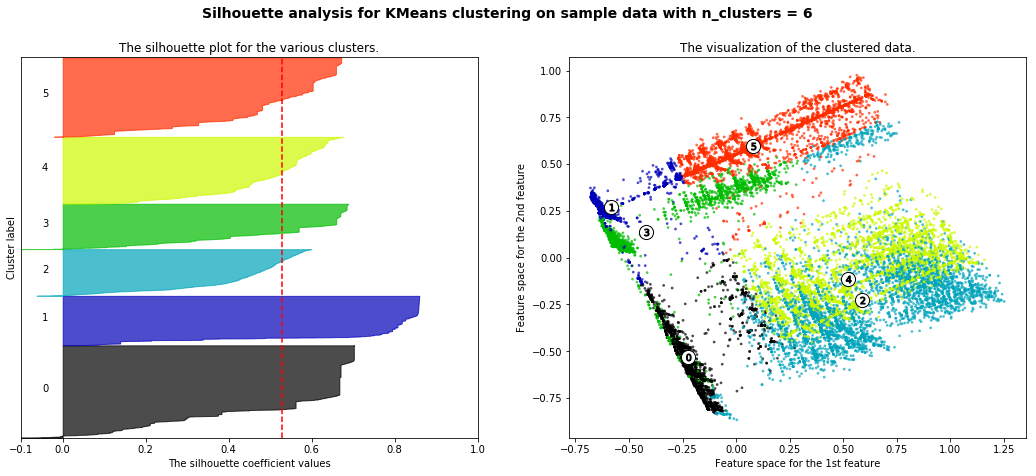

In [0]:
silhouette_score_sk(X_deg)

- Para ambos casos 2 y 3 clústers cumplen la tarea de clustering, aunque no de forma satifactoría dado que a simple vista no están bien definidos los clústers.

Para ejecutar el algoritmo de clustering se hará lo mismo, utilizar ambos datasets para comparar los grupos finales.

In [0]:
kmeans = KMeans(n_clusters=3).fit(X)
kmeans_3comp = KMeans(n_clusters=3).fit(X_deg)

In [0]:
kmeans.cluster_centers_

array([[ 5.89462443e-01, -1.47457635e-01,  1.17553226e-02,
        -1.14726930e-01,  3.75512177e-02,  4.53161118e-03,
        -1.00184167e-03,  9.31711849e-03,  5.04005295e-03,
         3.09141869e-03,  1.87571473e-03, -1.40244289e-03,
         1.08434493e-03,  2.71904099e-03,  3.22936878e-03,
         5.59408121e-05,  1.36028370e-03, -1.64309847e-03,
        -6.83547726e-04,  9.85234659e-04,  3.27618585e-04,
         3.81008780e-04, -8.58749460e-04,  2.73395907e-04,
         1.04873755e-04, -2.54829689e-04,  3.92966926e-04,
         1.79908071e-04,  2.74117614e-04,  8.60212496e-04,
         9.59905289e-05,  1.34030256e-04, -4.53257577e-04,
        -1.34212550e-05, -4.29227667e-04, -1.95534725e-04,
        -1.08517870e-04,  2.19018248e-04, -1.70662809e-04,
        -4.85565545e-04, -3.55504601e-05,  3.80156519e-04,
         4.76293949e-05, -1.21612554e-04, -7.48573269e-05,
         1.53646538e-05,  7.53922880e-05, -1.00042701e-04,
        -2.53267460e-04],
       [-2.30199446e-01,  3.98

In [0]:
kmeans.cluster_centers_.shape

(3, 49)

In [0]:
pd.Series(kmeans.predict(X)).value_counts()

1    17197
2    10557
0     9999
dtype: int64

In [0]:
pd.Series(kmeans_3comp.predict(X_deg)).value_counts()

1    17143
0    10421
2    10189
dtype: int64

In [0]:
pd.Series(kmeans.predict(X))

0        1
1        1
2        0
3        1
4        2
        ..
37748    1
37749    2
37750    1
37751    1
37752    1
Length: 37753, dtype: int32

In [0]:
pd.Series(kmeans_3comp.predict(X_deg))

0        1
1        1
2        0
3        1
4        2
        ..
37748    1
37749    2
37750    1
37751    1
37752    1
Length: 37753, dtype: int32

In [0]:
df_rating_animes.shape

(37753, 81)

In [0]:
df_rating_animes['cluster_n_comp'] = kmeans.predict(X)
df_rating_animes['cluster_3_comp'] = kmeans_3comp.predict(X_deg)

In [0]:
df_rating_animes.groupby(['cluster_n_comp']).mean()

mean      ...       cluster_3_comp
name                AWOL      ...                     
cluster_n_comp                ...                     
0               0.000000      ...             0.038504
1               0.000116      ...             0.995697
2               0.000000      ...             1.895709

[3 rows x 82 columns]

In [0]:
df_rating_animes.groupby(['cluster_3_comp']).mean()

mean      ...       cluster_n_comp
name                AWOL      ...                     
cluster_3_comp                ...                     
0               0.000000      ...             0.112849
1               0.000117      ...             0.998717
2               0.000000      ...             1.964275

[3 rows x 82 columns]

A simple vista se ven cambios muy bruscos al reducir tan drásticamente el número de componentes

In [0]:
print(df_rating_animes.loc[df_rating_animes.cluster_n_comp == 0].mean().sort_values(ascending=False)[:10].to_string())

      name                                              
mean  Clannad                                               8.546279
      Suzumiya Haruhi no Yuuutsu                            8.334848
      Lucky☆Star                                            4.008659
      Kore wa Zombie Desu ka?                               3.167734
      Seiken no Blacksmith                                  1.040469
      GJ-bu                                                 0.998240
      Paradise Kiss                                         0.790866
      Peace Maker Kurogane                                  0.338710
      Tantei Opera Milky Holmes                             0.331179
      Fate/kaleid liner Prisma☆Illya: Undoukai de Dance!    0.297855


In [0]:
print(df_rating_animes.loc[df_rating_animes.cluster_3_comp == 0].mean().sort_values(ascending=False)[:10].to_string())

      name                                              
mean  Clannad                                               8.519865
      Suzumiya Haruhi no Yuuutsu                            7.950535
      Lucky☆Star                                            4.390347
      Kore wa Zombie Desu ka?                               3.362855
      GJ-bu                                                 1.046400
      Seiken no Blacksmith                                  1.043846
      Paradise Kiss                                         0.768504
      Tantei Opera Milky Holmes                             0.342910
      Peace Maker Kurogane                                  0.331030
      Fate/kaleid liner Prisma☆Illya: Undoukai de Dance!    0.306213


In [0]:
print(df_rating_animes.loc[df_rating_animes.cluster_n_comp == 1].mean().sort_values(ascending=False)[:10].to_string())

                name                      
mean            Suzumiya Haruhi no Yuuutsu    3.695264
                Lucky☆Star                    2.246565
                Kore wa Zombie Desu ka?       2.225160
                Paradise Kiss                 1.093320
cluster_n_comp                                1.000000
cluster_3_comp                                0.995697
mean            Seiken no Blacksmith          0.570808
                Peace Maker Kurogane          0.381037
                GJ-bu                         0.375003
                Memories                      0.353197


In [0]:
print(df_rating_animes.loc[df_rating_animes.cluster_3_comp == 1].mean().sort_values(ascending=False)[:10].to_string())

                name                      
mean            Suzumiya Haruhi no Yuuutsu    3.671163
                Lucky☆Star                    2.211671
                Kore wa Zombie Desu ka?       2.195300
                Paradise Kiss                 1.100089
cluster_3_comp                                1.000000
cluster_n_comp                                0.998717
mean            Seiken no Blacksmith          0.565190
                Peace Maker Kurogane          0.380652
                GJ-bu                         0.363059
                Memories                      0.354123


El clúster número 1 queda muy parecido entre ambos resultados, incluso en el mismo orden

In [0]:
print(df_rating_animes.loc[df_rating_animes.cluster_n_comp == 2].mean().sort_values(ascending=False)[:10].to_string())

                name                                
mean            Clannad                                 8.546648
cluster_n_comp                                          2.000000
mean            Kore wa Zombie Desu ka?                 1.943547
cluster_3_comp                                          1.895709
mean            Lucky☆Star                              1.032123
                Paradise Kiss                           0.486426
                Seiken no Blacksmith                    0.426187
                GJ-bu                                   0.341784
                Peace Maker Kurogane                    0.142525
                One Piece: Mezase! Kaizoku Yakyuu Ou    0.115141


In [0]:
print(df_rating_animes.loc[df_rating_animes.cluster_3_comp == 2].mean().sort_values(ascending=False)[:10].to_string())

                name                      
mean            Clannad                       8.514651
cluster_3_comp                                2.000000
cluster_n_comp                                1.964275
mean            Kore wa Zombie Desu ka?       1.745013
                Lucky☆Star                    0.583609
                Paradise Kiss                 0.488516
                Seiken no Blacksmith          0.407509
                GJ-bu                         0.285611
                Suzumiya Haruhi no Yuuutsu    0.151470
                Peace Maker Kurogane          0.144165


El clúster 3 si bien tiene coincidencias entre ambos, los resultados son muy distintos.

# Conclusión

Los animes correspondientes a cada clúster son los animes que se le pueden recomendar al usuario perteneciente al clúster. Además con estos clústers obtenidos se pueden hacer más estudios con respecto a los datos presentes en cada clúster al relacionarlo con la tabla(o dataframe) *df_anime* tales como:
   - Ideintificar tipos de anime.
   - Identificar géneros.
   - Hacer un extenso análisis de los episodios en los animes de los diferentes clústers.
   - Clasificar otros usuarios.

# Falencias del modelo

Creo que el hecho de utilizar como valor 0 el no haber visto un anime en la misma variable en donde se indica el gusto(rating) por el anime es incorrecto, puesto que al indicar 0 estamos indicando que el gusto por el anime es pésimo, esto aunque sea en escala del 1 al 10, ya que el modelo no tiene conocimiento de esta escala que es una convención humana, por lo que creo que este valor 0 distorciona este modelo basado en distancias.